#Проведение исследований с градиентным бустингом

In [13]:
# Импорт необходимых библиотек
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, f1_score
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt

In [14]:
# Шаг 1: Загрузка данных (California Housing Dataset)
data = fetch_california_housing(as_frame=True)
housing_data = data['data']
housing_target = data['target']

# Преобразуем целевые значения в категории для задачи классификации
housing_target_class = pd.cut(housing_target, bins=3, labels=["1", "2", "3"])

# Вывод данных
print("Данные о недвижимости:")
print(housing_data.head())

Данные о недвижимости:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


In [15]:
# Шаг 2: Разделение на обучающую и тестовую выборки
X_class = housing_data
X_reg = housing_data
y_class = housing_target_class
y_reg = housing_target

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Нормализация данных
scaler = StandardScaler()
X_train_class_scaled = scaler.fit_transform(X_train_class)
X_test_class_scaled = scaler.transform(X_test_class)
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

## Базовая модель для классификации

In [7]:
# Базовая модель для классификации
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_classifier.fit(X_train_class_scaled, y_train_class)
y_pred_class = gb_classifier.predict(X_test_class_scaled)

# Оценка качества классификации
accuracy = accuracy_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class, average='weighted')
print(f"Классификация: Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")

Классификация: Accuracy = 0.8270, F1 = 0.8263


## Базовая модель для регрессии

In [8]:
# Базовая модель для регрессии
gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_regressor.fit(X_train_reg_scaled, y_train_reg)
y_pred_reg = gb_regressor.predict(X_test_reg_scaled)

# Оценка качества регрессии
mse = mean_squared_error(y_test_reg, y_pred_reg)
print(f"Регрессия: MSE = {mse:.4f}")

Регрессия: MSE = 0.2940


## Оптимизация гиперпараметров

In [9]:
from sklearn.model_selection import GridSearchCV

# Оптимизация гиперпараметров для классификации
param_grid_class = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
grid_class = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_class, scoring='f1_weighted', cv=5)
grid_class.fit(X_train_class_scaled, y_train_class)

best_gb_classifier = grid_class.best_estimator_
print(f"Лучшие параметры для классификации: {grid_class.best_params_}")

# Оценка оптимизированной модели классификации
y_pred_class_opt = best_gb_classifier.predict(X_test_class_scaled)
accuracy_opt = accuracy_score(y_test_class, y_pred_class_opt)
f1_opt = f1_score(y_test_class, y_pred_class_opt, average='weighted')
print(f"Оптимизированная классификация: Accuracy = {accuracy_opt:.4f}, F1 = {f1_opt:.4f}")

# Оптимизация гиперпараметров для регрессии
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
grid_reg = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_reg, scoring='neg_mean_squared_error', cv=5)
grid_reg.fit(X_train_reg_scaled, y_train_reg)

best_gb_regressor = grid_reg.best_estimator_
print(f"Лучшие параметры для регрессии: {grid_reg.best_params_}")

# Оценка оптимизированной модели регрессии
y_pred_reg_opt = best_gb_regressor.predict(X_test_reg_scaled)
mse_opt = mean_squared_error(y_test_reg, y_pred_reg_opt)
print(f"Оптимизированная регрессия: MSE = {mse_opt:.4f}")


Лучшие параметры для классификации: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Оптимизированная классификация: Accuracy = 0.8561, F1 = 0.8554
Лучшие параметры для регрессии: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Оптимизированная регрессия: MSE = 0.2071


## Реализация градиентного бустинга вручную

In [27]:
from sklearn.tree import DecisionTreeRegressor

class CustomGradientBoosting:
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X, y):
        # Инициализация модели (среднее значение или нулевая модель)
        residual = y.copy()  # остаток
        for _ in range(self.n_estimators):
            # Обучаем модель на остатке (по сути, дерево, которое аппроксимирует ошибку)
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)
            # Модель предсказывает ошибку
            pred = tree.predict(X)
            #residual -= self.learning_rate * pred  # Корректируем остаток
            self.trees.append(tree)

    def predict(self, X):
        # В прогнозе суммируем предсказания всех деревьев
        pred = np.zeros(X.shape[0])
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        return pred


# Обучение кастомной модели для классификации
custom_gb_classifier = CustomGradientBoosting(n_estimators=10, learning_rate=0.1, max_depth=3)
custom_gb_classifier.fit(X_train_class_scaled, y_train_class)
y_pred_class_custom = custom_gb_classifier.predict(X_test_class_scaled)

# Для классификации можно округлить результат в категории
y_pred_class_custom = np.round(y_pred_class_custom).astype(int)

accuracy_custom = accuracy_score(y_test_class, y_pred_class_custom)
print(f"Кастомная классификация: Accuracy = {accuracy_custom:.4f}")

# Обучение кастомной модели для регрессии
custom_gb_regressor = CustomGradientBoosting(n_estimators=10, learning_rate=0.1, max_depth=3)
custom_gb_regressor.fit(X_train_reg_scaled, y_train_reg)
y_pred_reg_custom = custom_gb_regressor.predict(X_test_reg_scaled)

mse_custom = mean_squared_error(y_test_reg, y_pred_reg_custom)
print(f"Кастомная регрессия: MSE = {mse_custom:.4f}")


Кастомная классификация: Accuracy = 0.6262
Кастомная регрессия: MSE = 0.6424


## Визуализация

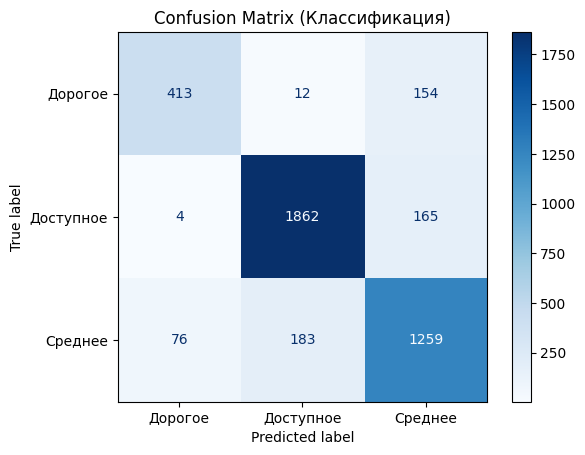

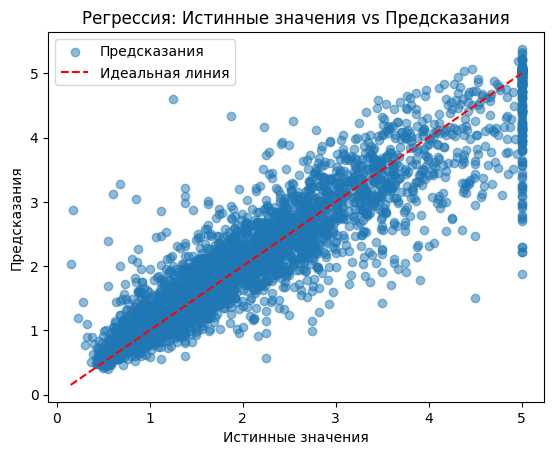

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Классификация: Confusion Matrix
cm = confusion_matrix(y_test_class, y_pred_class_opt, labels=grid_class.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_class.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Классификация)")
plt.show()

# Регрессия: График предсказаний vs Истинные значения
plt.scatter(y_test_reg, y_pred_reg_opt, alpha=0.5, label="Предсказания")
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', label="Идеальная линия")
plt.xlabel("Истинные значения")
plt.ylabel("Предсказания")
plt.title("Регрессия: Истинные значения vs Предсказания")
plt.legend()
plt.show()
